In [ ]:
%load_ext autoreload
%autoreload 2
%cd ..

In [ ]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from tqdm import tqdm

warnings.filterwarnings("ignore")

from notebooks.utils import *

## Loading

In [87]:
MOLSTRAL_PATH = Path("MolGenOutput/test_ood")
FIG_PATH = "/home/philippe/-Philippe-MolGenDocking/Figures/Results/MolGen"
os.makedirs(FIG_PATH, exist_ok=True)

files = [f for d in MOLSTRAL_PATH.iterdir() for f in d.iterdir() if "error" not in str(f) and str(f).endswith("scored.jsonl")]
files = sorted(files)
print("Total files:", len(files))
df = load_molgen_results(files[:])

sub_sample_prompts = df[df.Model == "ChemDFM-R"].prompt_id.unique()[:]


100%|██████████| 84/84 [00:44<00:00,  1.90it/s]


# Validity Plot

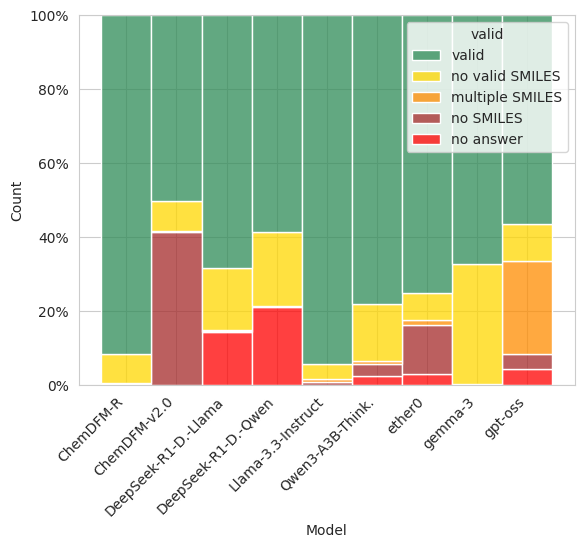

In [88]:
cmap = {
    "valid": "seagreen",
    "no valid SMILES": "gold",
    "multiple SMILES": "darkorange",
    "no SMILES": "brown",
    "no answer": "red"
}

ax = sns.histplot(data=df, x="Model", hue="valid", multiple="stack", stat="count", palette= cmap, hue_order=list(cmap.keys()))
# rotate x labels
max_count = 128_000
ax.set_ylim(0, max_count)

yticks = np.linspace(0, max_count, 6)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{int(y / max_count * 100)}%" for y in yticks])
_ = plt.xticks(rotation=45, ha='right')
# Replace y_ticks with percentages from 0 to 100

plt.savefig(f"{FIG_PATH}/validity.pdf", bbox_inches='tight')

# Diversity-Aware Top-k Score

In [89]:
fig_name =FIG_PATH + "/diversity_rewards/{}"
os.makedirs(FIG_PATH + "/diversity_rewards", exist_ok=True)
from notebooks.utils import CMAP_MODELS, MARKER_MODELS

def plot_div_topk(
    df,
    fp_name,
    legend=False,
    cols_vals = [10,30],
    x_vals=None,
    row="n_rollout",
    col="k",
    x="sim",
    **kwargs
):
    def draw(data, **kwargs):
        sns.lineplot(
            data,
            x = x,
            y = "value",
            hue = "Model",
            style = "Model",
            sizes=1,
            alpha=0.8,
            palette = CMAP_MODELS,
            hue_order = CMAP_MODELS.keys(),
            markers=MARKER_MODELS,
            dashes=False,
            legend=legend,
            **kwargs
        )
    div_clus_df = get_top_k_div_df(
        df[df.prompt_id.isin(sub_sample_prompts[:])], fp_name=fp_name, **kwargs
    )
    if not cols_vals is None:
        div_clus_df = div_clus_df[div_clus_df[col].isin(cols_vals)]
    if not x_vals is None:
        div_clus_df = div_clus_df[div_clus_df[x].isin(x_vals)]
    g = sns.FacetGrid(
        div_clus_df,
        row=row,
        col=col,
        margin_titles=True,
        height=1.7,
        aspect=1.3,
    )
    g.map_dataframe(draw, markersize=5,linewidth=1.8, markeredgewidth=.3)
    # Add legend to the top right
    g.set_axis_labels("", "")

    return g

sim: 0.99, n_rollout: 100: 100%|██████████| 39/39 [09:04<00:00, 13.97s/it]               


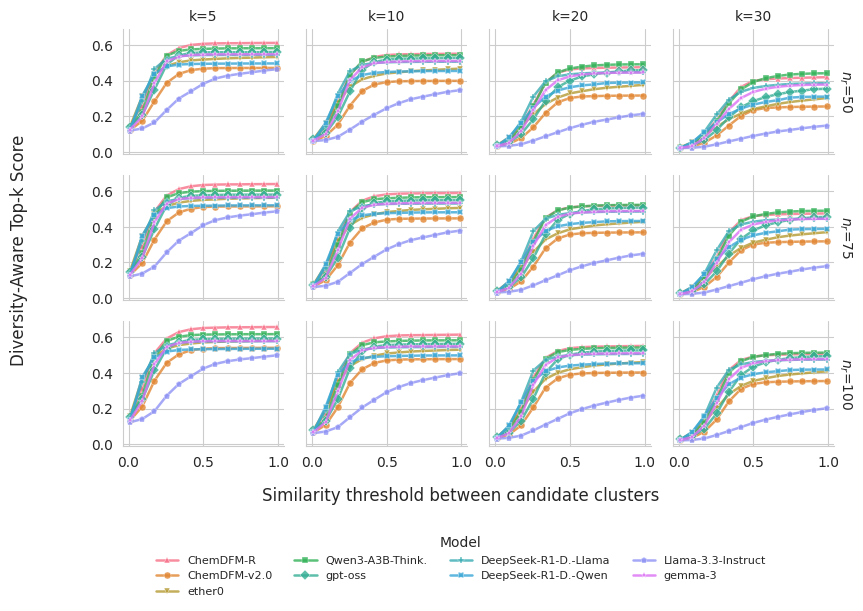

In [91]:
g = plot_div_topk(
    df = df,
    fp_name= "rdkit",
    cols_vals=[5,10,20,30],
    sim_values = np.linspace(0.01, 0.99, 13).tolist(),
    legend=True,
)
g.set_titles(row_template="$n_r$={row_name}", col_template="k={col_name}")
g.fig.supxlabel("Similarity threshold between candidate clusters", y=0., x = 0.3)
g.fig.supylabel("Diversity-Aware Top-k Score", x=0.0)
g.add_legend(
    title="Model", loc="lower center", bbox_to_anchor=(0.3, -0.2), ncols = 4, fontsize = 8, title_fontsize = 10
)
plt.savefig(f"{fig_name.format('rdkit') + '-main'}.pdf", bbox_inches='tight')
plt.show()

In [ ]:
for fp_name in [
    # "ecfp4-1024",
    "ecfp4-2048",
    # "ecfp6-1024",
    "ecfp6-2048",
    "maccs",
    # "rdkit",
    "Gobbi2d",
    "Avalon"
]:
    g = plot_div_topk(
        df = df,
        fp_name= fp_name,
        legend=fp_name=="Avalon",
    )

    g.set_titles(row_template="$n_r$={row_name}", col_template="k={col_name}")
    g.fig.supxlabel("Similarity threshold between candidate clusters", y=0., x = 0.5)
    g.fig.supylabel("Diversity-Aware Top-k Score", x=0.0)
    g.add_legend(
            title="Model", loc="lower center", bbox_to_anchor=(0.9, 0.5), ncols = 1, fontsize = 8, title_fontsize = 10
        )
    g.fig.suptitle(fp_name, y=1.05)
    plt.savefig(f"{fig_name.format(fp_name)}.pdf", bbox_inches='tight')
    plt.show()

  1%|          | 12129/1152000 [00:01<03:04, 6161.60it/s]

In [ ]:
g = plot_div_topk(
        df = df,
        fp_name= "rdkit",
        col="sim",
        x="k",
        k_max=50,
        cols_vals = [0.3,0.5,0.7,0.8],
        sim_values = [0.3,0.5,0.7,0.8],
        x_vals = [1] + [i for i in range(5,50,5)]
    )

g.set_titles(row_template="$n_r$={row_name}", col_template="k={col_name}")
g.fig.supxlabel("Similarity threshold between candidate clusters", y=0., x = 0.3)
g.fig.supylabel("Diversity-Aware Top-k Score", x=0.0)
g.add_legend(
    title="Model", loc="lower center", bbox_to_anchor=(0.3, -0.2), ncols = 4, fontsize = 8, title_fontsize = 10
)
g.fig.suptitle(fp_name, y=1.05)
plt.savefig(f"{fig_name.format('rdkit') + '_kx-main'}.pdf", bbox_inches='tight')
plt.show()

# Rank Heatmaps

In [ ]:
k_values = [1,10,30]
topk_dfs = []
ROLLOUTS_AT_K = {
    1: [10, 25, 50],
    10: [25, 50, 75],
    30: [50, 75, 100],
}

for k in tqdm(k_values):
    roll_values = ROLLOUTS_AT_K[k]

    topk_df = df[df.validity == 1].drop_duplicates(subset=["prompt_id", "smiles"]).groupby(
        ["Model", "prompt_id"]
    ).agg(
        **{f"{roll}":pd.NamedAgg(column="reward", aggfunc=aggregate_molgen_fn("topk", k=k, n_rollout=roll)) for roll in roll_values}
    ).reset_index()
    topk_df["k"] = k
    topk_df = topk_df.melt(id_vars=["prompt_id","Model", "k"], value_vars=[str(k) for k in roll_values], var_name="n_rollout", value_name= "top-k")
    topk_df["n_rollout"] = topk_df["n_rollout"].apply(int)

    topk_dfs.append(topk_df)

topk_df = pd.concat(topk_dfs).reset_index(drop=True)
topk_df["rank"] = topk_df.groupby(["prompt_id", "k", "n_rollout"])["top-k"].rank(ascending=False)

In [ ]:
def sort_prompt_ids(sub_df, y_order, r_max=2):
    x_order = []
    for model in y_order:
        first_rank = sub_df[(sub_df.Model == model) & (sub_df["rank"] == r_max-1)].prompt_id.tolist()
        # sort_first_rank = sub_df[(sub_df.Model == y_order[0]) & (sub_df.prompt_id.isin(first_rank))].sort_values(by="rank")
        # first_rank = sort_first_rank.prompt_id.tolist()
        x_order.append(first_rank)
        maybe_rank = sub_df[(sub_df.Model == model) & (sub_df["rank"] < r_max) & (sub_df["rank"] > r_max-1)]
        maybe_rank = [r for r in maybe_rank.prompt_id.tolist() if r not in x_order]
        x_order.append(maybe_rank)
    return x_order

def sort_recursive_prompts(sub_df, y_order, to_sort, r_max):
    if len(to_sort) <=1:
        return to_sort
    if r_max >= 8:
        return to_sort
    groups = sort_prompt_ids(sub_df, y_order, r_max=r_max)
    return sum(
        [sort_recursive_prompts(sub_df[sub_df.prompt_id.isin(g)], y_order, g, r_max +1) for g in groups],
        []
    )

In [ ]:
y_order = topk_df.groupby("Model")["rank"].mean().sort_values().index.tolist()

# Immense heatmap of ranks
for k in tqdm(k_values):
    roll_values = ROLLOUTS_AT_K[k]
    for n_rolls in roll_values:
        sub_df = topk_df[(topk_df.k == k) & (topk_df.n_rollout==n_rolls)]
        # Order rows by: where the first model has the rank 1, then the second model has rank 1, ...
        x_order = sort_recursive_prompts(sub_df, y_order, sub_df.prompt_id.unique().tolist(), r_max=2)
        # for model in y_order:
        #     first_rank = sub_df[(sub_df.Model == model) & (sub_df["rank"] == 1)].prompt_id.tolist()
        #     # sort_first_rank = sub_df[(sub_df.Model == y_order[0]) & (sub_df.prompt_id.isin(first_rank))].sort_values(by="rank")
        #     # first_rank = sort_first_rank.prompt_id.tolist()
        #     x_order.extend(first_rank)
        #     # See where it is between 1 and 2
        #     maybe_rank = sub_df[(sub_df.Model == model) & (sub_df["rank"] < 2)]
        #     for r in maybe_rank.prompt_id.tolist():
        #         if r not in x_order:
        #             x_order.append(r)
        heat_kwargs = {
            "cmap":"magma_r",
            "vmin":1,
            "vmax":len(y_order),
        }
        heatmap_df = sub_df.pivot_table(index="Model", columns=["prompt_id"], values="rank")
        heatmap_df = heatmap_df.reindex(index=y_order, columns=x_order)
        fig, axes = plt.subplots(1, 3, figsize=(8,3), gridspec_kw={"width_ratios":[18,1,0.2], "wspace":0.05})

        sns.heatmap(heatmap_df, cbar=None, ax = axes[0], **heat_kwargs)
        sns.heatmap(heatmap_df.mean(1).to_frame(), cbar = None, ax = axes[1], annot = True, fmt=".1f", **heat_kwargs)

        fig.suptitle(f"Top-{k} / {n_rolls} Score Ranks across Models and Prompts")
        for ax in axes:
            ax.set_xlabel("")
            ax.set_ylabel("")
            # remove xticks
        axes[0].set_xticks([])
        # set xtick label to "avg" for the second heatmap
        axes[1].set_xticks([0.5])
        axes[1].set_xticklabels(["avg"])
        axes[1].set_yticks([])

        # colorbar for the first heatmap in axes[2]
        cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="magma_r", norm=plt.Normalize(vmin=1, vmax=len(y_order))), cax=axes[2])
        cbar.set_label("Rank")
        os.makedirs(f"{FIG_PATH}/heatmap", exist_ok=True)
        plt.savefig(f"{FIG_PATH}/heatmap/topk_{k}_{n_rolls}_ranks_heatmap.pdf", bbox_inches='tight')
        plt.show()
    #     break
    # break

# Uniqueness and Diversity Metrics

## Computations

Compute the uniqueness of the generated smiles in each prompt

In [ ]:
uniq_df = df[df.validity == 1].groupby(["Model", "prompt_id"]).agg(
    **{f"{k}":pd.NamedAgg(column="smiles", aggfunc=aggregate_molgen_fn("uniqueness", k)) for k in list(range(1,100,10))}
).reset_index()
uniq_df = uniq_df.melt(id_vars=["Model"], value_vars=[str(k) for k in list(range(1,100,10))], var_name="n_rollout")
uniq_df["n_rollout"] = uniq_df["n_rollout"].apply(int)

Diversity in each prompt (ecfp4)

In [ ]:
fp_fn = fp_name_to_fn("ecfp4-2048")
sub_df = df[
    (df.validity == 1) & (df.prompt_id.isin(sub_sample_prompts))
].drop_duplicates(subset=["prompt_id", "smiles"])
sub_df["fps"] = sub_df["smiles"].progress_apply(lambda x: fp_fn(Chem.MolFromSmiles(x)))

sim_df = sub_df.groupby(["Model", "prompt_id"]).agg(
    **{
        f"{k}":pd.NamedAgg(
            column="fps",
            aggfunc=aggregate_molgen_fn("diversity",k, is_fp=True))
        for k in [50]
    }
).reset_index()
sim_df = sim_df.melt(id_vars=["Model"], value_vars=[str(k) for k in [50]], var_name="n_rollout")
sim_df["n_rollout"] = sim_df["n_rollout"].apply(int)

Uniqueness accross prompts

In [ ]:
uniqueness_ac_prompts = []

def topk_fn(k):
    def get_topk(x):
        return list(np.pad(x, (0, 100), 'constant', constant_values=None)[:k])
    return get_topk

def uniqueness_across_prompts(smiles_lists):
    smiles_conc = sum(smiles_lists, [])
    all_smiles = set(smiles_conc)
    return len(all_smiles) / len(smiles_conc)

for k in tqdm(range(2,101,10)):
    smiles_per_p = df[df.validity == 1].groupby(
        ["Model", "prompt_id"]
    ).smiles.apply(topk_fn(k)).reset_index()
    uniqueness_ac_prompts.append(
        smiles_per_p.groupby("Model").smiles.apply(
            uniqueness_across_prompts
        ).reset_index().rename(columns={"smiles":str(k)})
    )

uniq_ap_df = pd.concat(
    [sdf.set_index("Model") for sdf in uniqueness_ac_prompts], axis = 1
).reset_index().melt(id_vars=["Model"], value_vars=[str(k) for k in range(2,101,10)], var_name="n_rollout")
uniq_ap_df["n_rollout"] = uniq_ap_df["n_rollout"].apply(int)

## Plots

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9,3), sharey=False, gridspec_kw={"wspace":0.4})

ax = axes[0]
sns.lineplot(uniq_df, x="n_rollout", y="value", hue="Model", ax=ax, legend=True, palette=CMAP_MODELS, hue_order=CMAP_MODELS.keys())
ax.set_ylabel("Uniqueness-Prompt-wise")
ax.set_xlabel("$n_r$")
ax.set_ylim(0,1)
ax.set_xlim(5,100)
# Move legend below plot
ax.legend(bbox_to_anchor=(1.8, -.5), loc='lower center', ncols=4)

ax = axes[1]
sns.lineplot(uniq_ap_df, x="n_rollout", y="value", hue="Model", ax=ax, legend = False, palette=CMAP_MODELS)
ax.set_ylabel("Uniqueness-Across-Prompts")
ax.set_ylim(0.,1)
ax.set_xlim(5,100)
ax.set_xlabel("$n_r$")

ax = axes[2]
x_order = sim_df.groupby("Model")["value"].median().sort_values().index.tolist()
sns.boxplot(sim_df, x="Model", y="value", hue="Model", ax=ax, legend = False, order=x_order, palette=CMAP_MODELS)
ax.set_ylabel("Diversity-Prompt-wise")
ax.set_xlabel("")
ax.set_xticklabels([],)

fig.savefig(f"{FIG_PATH}/uniqueness_diversity.pdf", bbox_inches='tight')

# Top-k scores

In [ ]:
k_values = [1,5,10,20,30]
topk_dfs = []


for k in tqdm(k_values):
    roll_values = list(range(k+1,101,10))

    topk_df = df[
        (df.validity == 1) & (df.prompt_id.isin(sub_sample_prompts))
    ].drop_duplicates(subset=["prompt_id", "smiles"]).groupby(
        ["Model", "prompt_id"]
    ).agg(
        **{f"{roll}":pd.NamedAgg(column="reward", aggfunc=aggregate_molgen_fn("topk", k=k, n_rollout=roll)) for roll in roll_values}
    ).reset_index()
    topk_df["k"] = k
    topk_df = topk_df.melt(id_vars=["prompt_id","Model", "k"], value_vars=[str(k) for k in roll_values], var_name="n_rollout", value_name= "top-k")
    topk_df["n_rollout"] = topk_df["n_rollout"].apply(int)

    topk_dfs.append(topk_df)

topk_df = pd.concat(topk_dfs).reset_index(drop=True)

In [ ]:
fig,axes = plt.subplots(
    1,
    topk_df.k.nunique(),
    figsize=(3 * topk_df.k.nunique(),3),
    sharey=True,
    gridspec_kw={"wspace":0.1 }
)

for k, ax in zip(topk_df.k.unique(), axes):
    sns.lineplot(topk_df[
         topk_df.k == k
     ], x="n_rollout", y="top-k", hue="Model", ax=ax, legend = k==30, palette=CMAP_MODELS, hue_order=CMAP_MODELS.keys())
    ax.set_ylabel("top-k score")
    ax.set_title(f"k = {k}")
# Move legend of the last axis below plot
axes[-1].legend(bbox_to_anchor=(-1.8, -0.5), loc='lower center', ncols=4)

fig.savefig(f"{FIG_PATH}/topk_k_score.pdf", bbox_inches='tight')

# Tables for Top-k

In [ ]:
from notebooks.metadata.molgen import MODEL_META

In [ ]:
# Create table with: model_name, size, metric_name, value
import re

ROLLOUTS_AT_K = {
    1: [10, 25, 50],
    10: [25, 50, 75],
    30: [50, 75, 100],
}

table = pd.DataFrame(columns=["Model", "Size", "Think.", "Metric", r"$n_\text{rollouts}$", "Value"])
size_pattern = re.compile(r'(?i)(?:^|[-_])(\d+\s*[b])(?:$|[-_])')
pbar = tqdm(total=len(df.model.unique())*sum([len(ROLLOUTS_AT_K[k]) for k in ROLLOUTS_AT_K]))

for model_name in df.model.unique():
    assert any([m in model_name for m in MODEL_META.keys()])
    key = [m for m in MODEL_META.keys() if m in model_name][0]
    metadata = MODEL_META[key]
    pbar.set_description(f"{model_name}")
    pbar.refresh()
    for k in ROLLOUTS_AT_K:
        for n_rollout in ROLLOUTS_AT_K[k]:
            sub_df = df[df.model == model_name]
            sub_df = sub_df.drop_duplicates(subset=["prompt_id", "smiles"])
            pass_k = sub_df.groupby("prompt_id").agg(
                **{f"{k}":pd.NamedAgg(column="reward", aggfunc=aggregate_molgen_fn("topk",k=k, n_rollout=n_rollout))}
            )

            if not "size" in metadata:
                try:
                    size = size_pattern.search(model_name).group(1).upper()
                except:
                    raise ValueError(f"Size not found for model {model_name}")
            else:
                size = metadata["size"]
            for i, row in pass_k.iterrows():
                thinking = r"\CheckmarkBold" if metadata["thinking"] else r"\XSolidBrush"
                chem = r"\CheckmarkBold" if metadata["Chem."] else r"\XSolidBrush"

                table.loc[len(table)] = [
                    model_name,
                    size,
                    thinking,
                    # chem,
                    f"top-{k}",
                    n_rollout,
                    row[str(k)]
                ]
            pbar.update(1)


In [ ]:
table["Model"] = table["Model"].apply(lambda x: re.sub(r"-\d+(B|b)", "", x).replace("-2507", "").replace("Distill", "D.").replace("-it", "").replace("Thinking", "Think."))

MODEL_ORDER = [
    "Qwen3-A3B-Think.",
    "DeepSeek-R1-D.-Llama",
    "DeepSeek-R1-D.-Qwen",
    "gemma-3",
    "gpt-oss",
    "Llama-3.3-Instruct",
    "ChemDFM-R",
    "ether0",
    "ChemDFM-v2.0",
]

table["N_rolls"] = table[r"$n_\text{rollouts}$"].apply(lambda x: r"$n_\text{r}=$" + str(x))
table["Model"] = table["Model"].apply(lambda x: x.replace("_", ""))
table

In [ ]:
table.Model.unique()

In [ ]:
LATEX_PATH = "/home/philippe/-Philippe-MolGenDocking/tables"

In [ ]:
formatter = PandasTableFormatter(
    n_decimals = 3, # Number of decimals to keep in the table
    aggregation_methods=["mean"], # Aggregation functions to apply to the data
    main_subset=0, # Subset of values to bold, here the first column will be bolded corresponding to the mean values, if [0,1] the first two columns will be bolded (independently)
    hide_agg_labels=True, # Hide the aggregation column names in the latex
    global_agg=False # Whether to compute global aggregation across all columns (True)
)

style = formatter.style(
    table, # Dataframe to format
    rows= ["Model", "Size", "Think."], # Rows
    cols=["Metric", r"N_rolls"], # Columns
    values= "Value", # Values
    highlight_fn= np.nanmax, # Function to use to highlight the values, here the maximum values will be highlighted
    props=["font-weight: bold; text-decoration: underline;", "text-decoration: underline"], # Properties to apply to the highlighted values, here the maximum values will be underlined and bolded, the second maximum values will be bolded
    special_format_agg = {
        "std": lambda x: "\\tiny $\\pm$" + x, # Format to apply to the standard deviation values
    },
    remove_col_names=True,
    row_order = MODEL_ORDER
)
formatter.save_to_latex(style, f"{LATEX_PATH}/gen_table.tex", 1, multicol_align="|c|", hrules=True, n_first_cols=2)
style

In [ ]:
formatter = PandasTableFormatter(
    n_decimals = 3, # Number of decimals to keep in the table
    aggregation_methods=["mean", "std"], # Aggregation functions to apply to the data
    main_subset=0, # Subset of values to bold, here the first column will be bolded corresponding to the mean values, if [0,1] the first two columns will be bolded (independently)
    hide_agg_labels=True, # Hide the aggregation column names in the latex
    global_agg=False # Whether to compute global aggregation across all columns (True)
)

style = formatter.style(
    table, # Dataframe to format
    rows= ["Model", "Size", "Think."], # Rows
    cols=["Metric", r"N_rolls"], # Columns
    values= "Value", # Values
    highlight_fn= np.nanmax, # Function to use to highlight the values, here the maximum values will be highlighted
    props=["font-weight: bold; text-decoration: underline;", "text-decoration: underline;"], # Properties to apply to the highlighted values, here the maximum values will be underlined and bolded, the second maximum values will be bolded
    special_format_agg = {
        "std": lambda x: "\\tiny $\\pm$" + x, # Format to apply to the standard deviation values
    },
    remove_col_names=True,
    row_order = MODEL_ORDER
)
formatter.save_to_latex(style, f"{LATEX_PATH}/gen_table_std.tex", 1, multicol_align="|c|", hrules=True, n_first_cols=2)